 # Dueling Deep Q Network

 ## Imports

In [1]:
import gym, math, glob
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta
from environments.BHS.environment_v4_2 import Environment

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv

from IPython.display import clear_output
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

from utils.wrappers import *
from agents.DQN import Model as DQN_Agent
from utils.ReplayMemory import ExperienceReplayMemory

from utils.hyperparameters import Config
from utils.plot import plot_all_data

Using backend: pytorch


 ## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#epsilon variables
config.epsilon_start = 1.0
config.epsilon_final = 0.01
config.epsilon_decay = 300000
config.epsilon_by_frame = lambda frame_idx: config.epsilon_final + (config.epsilon_start - config.epsilon_final) * math.exp(-1. * frame_idx / config.epsilon_decay)

#misc agent variables
config.GAMMA=0.99
config.LR=1e-4
config.USE_PRIORITY_REPLAY = True

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE = 50000
config.BATCH_SIZE = 32

#Learning control variables
config.LEARN_START = 100
config.MAX_FRAMES=1000000
config.UPDATE_FREQ = 1

#Nstep controls
config.N_STEPS=5

#data logging parameters
config.ACTION_SELECTION_COUNT_FREQUENCY = 1000

 ## Network

In [3]:
class BHSDuelingDQN(nn.Module):
    def __init__(self, input_shape, num_outputs, edgelist):
        super(BHSDuelingDQN, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_outputs # a vector of the number of actions at each diverter
        self.edge = edgelist       

        self.conv1 = GCNConv(self.input_shape[1], 128)
        self.conv2 = GCNConv(128, 256)
        
        self.adv = nn.Linear(self.feature_size(), sum(self.num_actions)) # Might be an idea to add another fc layer here

        self.val1 = nn.Linear(self.feature_size(), 64)
        self.val2 = nn.Linear(64, 64)
        self.val3 = nn.Linear(64, len(self.num_actions))

    def forward(self, x):        
        # x comes in as an N x H x C shape (N is batch size, H is number of elements (height), C is number of features (channels))
        x_shape = x.shape 
        x = x.view(x_shape[0]*x_shape[1],x_shape[2]) # set shape of x to [N*H, C] to get the shape of a Graph batch
        
        x = F.relu(self.conv1(x, self.edge))
        x = F.relu(self.conv2(x, self.edge))
        
        x = x.view(x_shape[0], -1) # set shape of x to [N,:] to keep the batch size
        
        adv = F.relu(self.adv(x))
        adv = adv.view(adv.size(0),len(self.num_actions),-1)
            
        val = F.relu(self.val1(x))
        val = F.relu(self.val2(val))
        val = self.val3(val)
        
        return val.unsqueeze(-1).expand_as(adv) + adv - adv.mean(-1).unsqueeze(-1).expand_as(adv)
    
    def feature_size(self):
        x = self.conv1(torch.zeros([self.input_shape[0],self.input_shape[1]],dtype=torch.float),torch.zeros([self.edge.shape[0],self.edge.shape[1]], dtype=torch.long))
        x = self.conv2(x,torch.zeros([self.edge.shape[0],self.edge.shape[1]], dtype=torch.long))
        x = x.view(1, -1)
        x = x.size(1)
        return x
    
    def sample_noise(self):
        #ignore this for now
        pass


 ## Agent

In [4]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None, log_dir='/tmp/GCN'):
        super(Model, self).__init__(static_policy, env, config, log_dir=log_dir)

    def declare_networks(self):
        edgelist = self.env.edgelist.to(self.device)
        self.model = BHSDuelingDQN(self.env.observation_space.shape, self.env.action_space.nvec, edgelist)
        self.target_model = BHSDuelingDQN(self.env.observation_space.shape, self.env.action_space.nvec, edgelist)


 ## Training Loop

58000
0.003007971672224812 0.0007852711221203208 0.10907292604946997


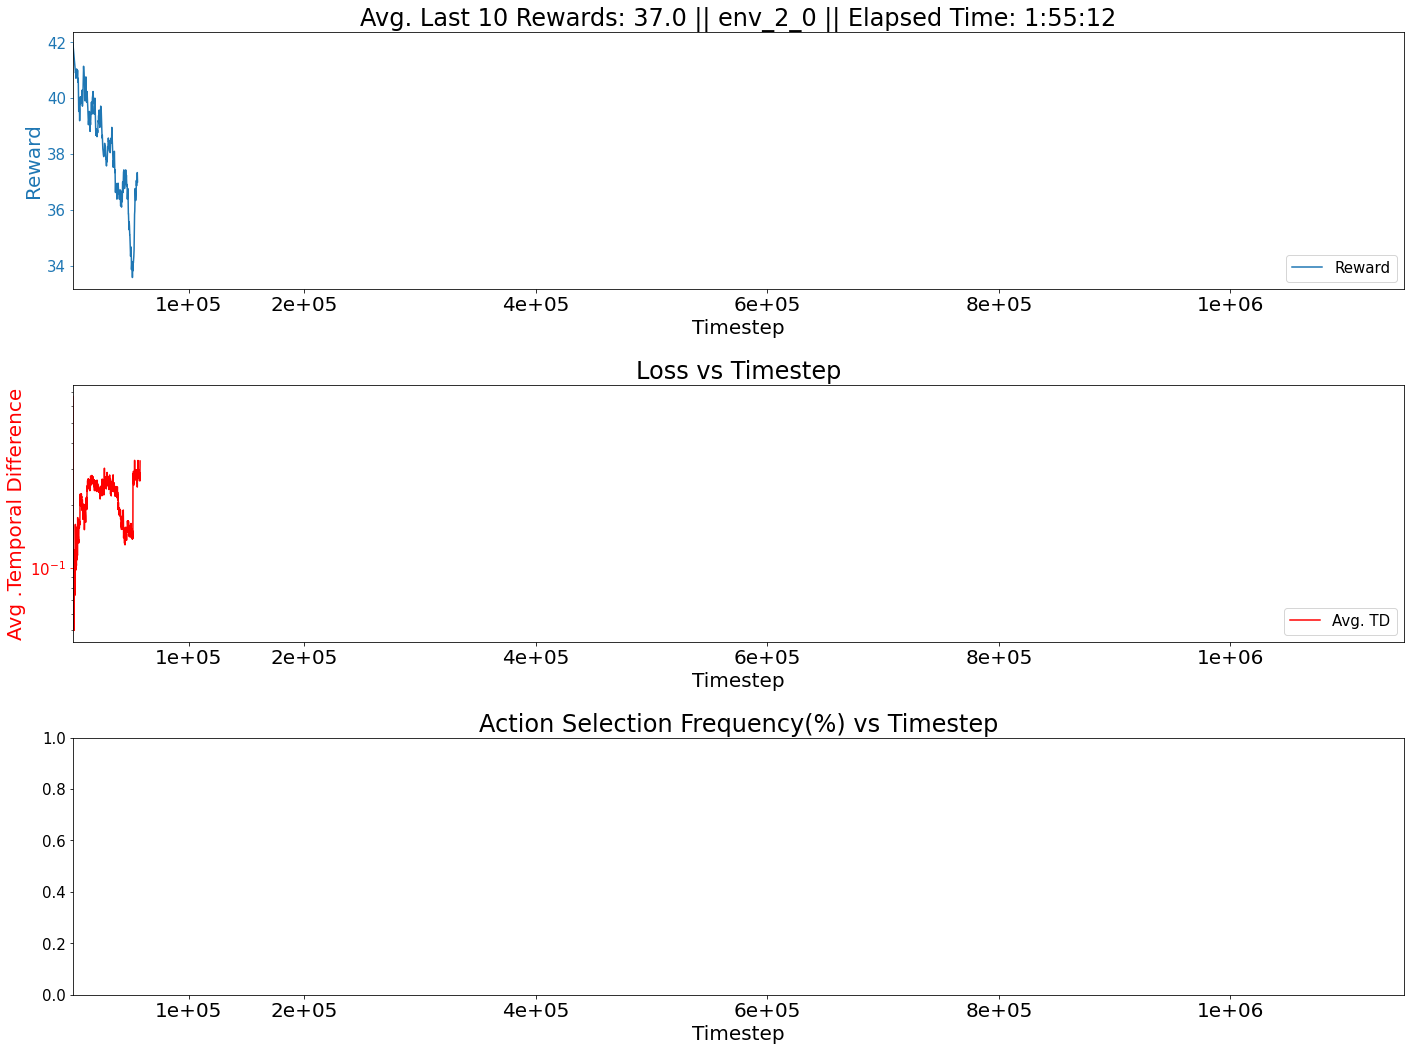

In [5]:
start=timer()

log_dir = "tmp/GCN/"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

class Arg_parser():
    def __init__(self):
        self.max_timesteps = 10000000
        self.envtype = 'env_2_0'
        self.tb_log_name = 'DQN'
        self.steplimit = 200
        self.log_interval = 1000
        self.step_penalty = None
        self.trasum_scale = None
        self.destination_score = None
        self.numtotes = 30
        self.randomize_numtotes = False
        self.RL_diverters = None
    
args = Arg_parser()

        
env_id = args.envtype
env    = Environment(args) #make_atari(env_id)
env    = bench.Monitor(env, os.path.join(log_dir, env_id))
# env    = wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=True)
# env    = ImageToPyTorch(env)
model  = Model(env=env, config=config, log_dir=log_dir)

episode_reward = 0
time_get, time_step, time_update = 0,0,0
observation = env.reset(total = True)
for frame_idx in range(1, config.MAX_FRAMES + 1):
    epsilon = config.epsilon_by_frame(frame_idx)
    
    start_get=timer()
    action = model.get_action(observation, epsilon)[0]
    time_get += timer()-start_get
    
    start_step=timer()
    prev_observation=observation
    observation, reward, done, _, actual_action = env.step(action)
    observation = None if env.deadlock else observation     
    time_step += timer()-start_step
    
    action = actual_action
    model.save_action(action, frame_idx) #log action selection
    
    start_update=timer()
    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward
    time_update += timer()-start_update   
    
    if frame_idx % args.steplimit*10 == 0:
        total_reset = True
    else:
        total_reset = env.deadlock
    if done:
        model.finish_nstep()
        model.reset_hx()
        
        observation = env.reset(total=total_reset)
        model.save_reward(episode_reward)
        episode_reward = 0
    
    
    if frame_idx % args.log_interval == 0:
        model.save_w()
        try:
            clear_output(True)
            print(frame_idx)
            print(time_get/args.log_interval, time_step/args.log_interval, time_update/args.log_interval)
            time_get, time_step, time_update = 0,0,0
            plot_all_data(log_dir, env_id, 'BHSDuelingDQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass

model.save_w()
env.close()
plot_all_data(log_dir, env_id, 'BHSDuelingDQN', config.MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)